<a href="https://colab.research.google.com/github/KRITIKA-GAHLAWAT/Modelling-Workshop/blob/main/fractal01101_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

#  Load the dataset
df = pd.read_csv("data.csv")

#  selected 9 features
selected_features = [
    "radius_mean",            # Lump Thickness
    "texture_mean",           # Uniformity of Cell Size
    "perimeter_mean",         # Uniformity of Cell Shape
    "area_mean",              # Marginal Adhesion
    "smoothness_mean",        # Single Epithelial Cell Size
    "compactness_mean",       # Bare Nuclei
    "concavity_mean",         # Bland Chromatin
    "concave points_mean",    # Normal Nucleoli
    "symmetry_mean"           # Mitoses
]

#  Drop missing values and select the features
X = df[selected_features].dropna()

#  Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# print shape for confirmation
print("Shape of feature matrix:", X_scaled.shape)


Shape of feature matrix: (569, 9)


In [ ]:
# prompt: write the code for train test split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['diagnosis'].dropna(), test_size=0.1, random_state=42)

# Print the shapes of the resulting datasets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (512, 9)
Shape of X_test: (57, 9)
Shape of y_train: (512,)
Shape of y_test: (57,)


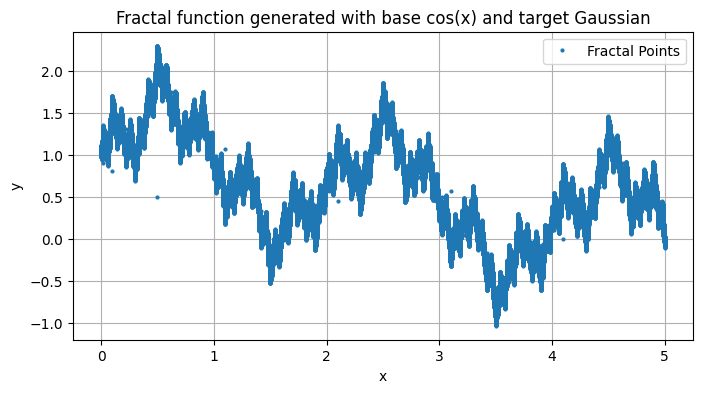

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ========= Fractal Class =========
class AlphaFractal:
    def __init__(self, scale_vector, b_func, f_func, interval, num_intervals, max_depth):
        self.scale_vector = scale_vector
        self.b_func = b_func
        self.f_func = f_func
        self.I = interval
        self.N = num_intervals
        self.max_depth = max_depth
        self.h = (self.I[1] - self.I[0]) / self.N
        self.transformations = []
        self.create_transformations()

    def create_transformations(self):
        for i in range(self.N):
            alpha = self.scale_vector[i]

            def L_i(x, i=i):
                return (x - self.I[0]) / self.N + self.I[0] + i * self.h

            def w(x, y, alpha=alpha, L_i=L_i):
                x_new = L_i(x)
                y_new = alpha * (y - np.cos(x)) + self.f_func(x_new)
                return x_new, y_new

            self.transformations.append(w)

    def generate_points(self, x0, y0):
        current_points = [(x0, y0)]
        points_x, points_y = [x0], [y0]

        for depth in range(self.max_depth):
            new_points = []
            for (x, y) in current_points:
                for transform in self.transformations:
                    new_x, new_y = transform(x, y)
                    points_x.append(new_x)
                    points_y.append(new_y)
                    new_points.append((new_x, new_y))
            current_points = new_points

        return points_x, points_y

    def falpha(self):
        x_vals, y_vals = self.generate_points(0.5, 0.5)

        sorted_indices = np.argsort(x_vals)
        x_sorted = np.array(x_vals)[sorted_indices]
        y_sorted = np.array(y_vals)[sorted_indices]

        unique_indices = np.unique(x_sorted, return_index=True)[1]
        x_unique = x_sorted[unique_indices]
        y_unique = y_sorted[unique_indices]

        f = interp1d(x_unique, y_unique, kind='linear', fill_value="extrapolate")
        return f

# ========= Fractal Building Function =========
def build_fractal_only(gamma, K, N_intervals=5, max_depth=8):
    d_values = np.linspace(0, K, N_intervals + 1)

    # Target function: Gaussian exp(-gamma * x^2)
    target_function = lambda x: np.exp(-gamma * (x**2))

    alpha_array = [0.5 if i % 2 == 0 else -0.5 for i in range(N_intervals)]

    alpha_fractal = AlphaFractal(
        scale_vector=alpha_array,
        b_func=np.cos,          # Base function: cos(x)
        f_func=target_function, # Target function: Gaussian
        interval=[0, K],
        num_intervals=N_intervals,
        max_depth=max_depth
    )

    return alpha_fractal

# ========= Plotting the Fractal =========
gamma = 0.1
K = 5        # Set K according to interval [0, K]
N_intervals = 5
max_depth = 8

alpha_fractal_obj = build_fractal_only(gamma, K, N_intervals, max_depth)

# Generate points
x_vals, y_vals = alpha_fractal_obj.generate_points(0.5, 0.5)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_vals, y_vals, 'o', markersize=2, label="Fractal Points")
plt.title("Fractal function generated with base cos(x) and target Gaussian")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.spatial.distance import cdist
import numpy as np

# --- Define the fractal_kernel function (with Euclidean distance) ---
def fractal_kernel(X1, X2, gamma=0.5, K=5, N_intervals=5, max_depth=8):
    # Step 1: Build the AlphaFractal object
    fractal_obj = build_fractal_only(gamma=gamma, K=K, N_intervals=N_intervals, max_depth=max_depth)

    # Step 2: Get the interpolated function from AlphaFractal
    f = fractal_obj.falpha()

    # Step 3: Compute Euclidean distance between all points
    dists = cdist(X1, X2, 'euclidean')

    # Step 4: Apply the fractal approximation function f to those distances
    K_matrix = f(dists)

    return K_matrix

# --- Clean and prepare the dataset ---
df = df[df["diagnosis"].notnull()]  # Remove rows where diagnosis is missing
df = df.dropna(subset=selected_features)  # Drop rows with missing features
df["diagnosis"] = df["diagnosis"].astype(str).str.strip()

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df["diagnosis"])

# Scale the features
X = df[selected_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ensure y and X are aligned
y = y[:X_scaled.shape[0]]

# Compute the fractal kernel matrix
K_train = fractal_kernel(X_scaled, X_scaled)

# Train SVM with precomputed kernel
clf = SVC(kernel='precomputed')
clf.fit(K_train, y)





SVC(kernel='precomputed')

In [ ]:
from sklearn.model_selection import train_test_split

# Split the scaled features and labels
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42, stratify=y
)

# Compute kernel matrices
K_train = fractal_kernel(X_train, X_train)       # kernel for training
K_test = fractal_kernel(X_test, X_train)         # test vs train (same column dimension as K_train)

# Train SVM on precomputed kernel
clf = SVC(kernel='precomputed')
clf.fit(K_train, y_train)

# Predict on test set
y_pred = clf.predict(K_test)

# Evaluate
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred) * 100)



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        54
           1       0.77      0.75      0.76        32

    accuracy                           0.83        86
   macro avg       0.81      0.81      0.81        86
weighted avg       0.82      0.83      0.82        86


Confusion Matrix:
[[47  7]
 [ 8 24]]

Accuracy Score: 82.55813953488372


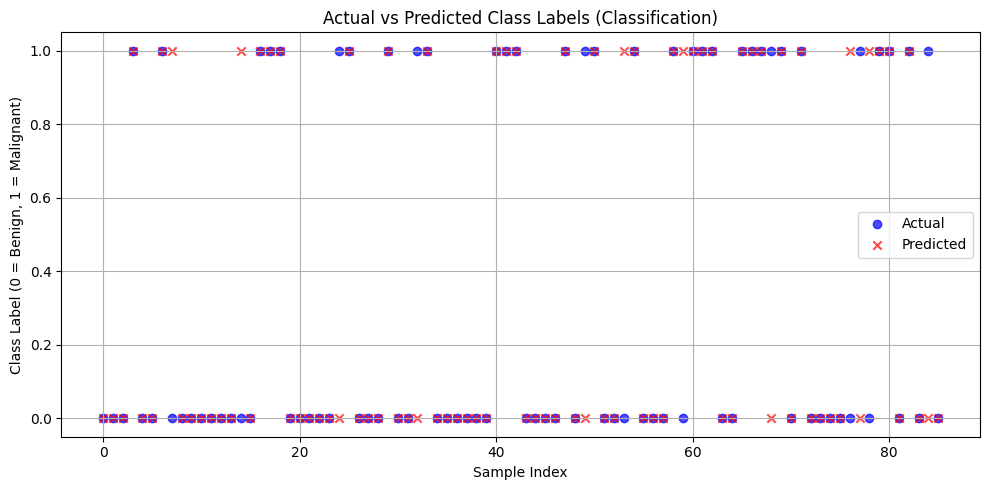

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot to show actual vs predicted classes
plt.figure(figsize=(10, 5))
indices = np.arange(len(y_test))

plt.scatter(indices, y_test, label='Actual', marker='o', color='blue', alpha=0.7)
plt.scatter(indices, y_pred, label='Predicted', marker='x', color='red', alpha=0.7)

plt.title("Actual vs Predicted Class Labels (Classification)")
plt.xlabel("Sample Index")
plt.ylabel("Class Label (0 = Benign, 1 = Malignant)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
